# GPT-5 최적화 메타 프롬프트 생성 에이전트

이 튜토리얼에서는 **GPT-5에 최적화된** 프롬프트 생성 시스템을 구축하는 방법을 다룹니다. 최신 OpenAI 프롬프트 가이드북의 모범 사례를 기반으로 하여, 사용자 요구사항을 지능적으로 수집하고 고품질 프롬프트를 생성하는 AI 에이전트를 만들어보겠습니다.

## 🚀 주요 개선사항 (GPT-5 최적화)

### 📊 **향상된 데이터 모델**
- **유연한 구조**: 필수 필드(objective, context)와 선택적 필드로 구성
- **GPT-5 특화 기능**: reasoning_approach, persona, escalation_conditions 지원
- **실용적 설계**: output_format, tone_style, examples로 구체적 가이드 제공

### 🧠 **지능적 요구사항 수집**
- **병렬 발견**: 초기 요구사항을 구체적인 하위 질문으로 분해
- **적응형 질문**: 프롬프트 유형에 따른 맞춤형 질문 시스템
- **명확한 중단 조건**: 충분한 정보 수집 시점을 정확히 판단

### 🎯 **최신 메타 프롬프트 엔진**
- **XML 구조화**: 명확한 지시문과 안전장치 구현
- **추론 우선**: 결론보다 추론 과정을 우선시하는 설계
- **안전성 강화**: 에스컬레이션 조건과 안전 가이드라인 내장

## 🏗️ **시스템 아키텍처**

이 시스템은 두 개의 주요 상태로 구성됩니다:

1. **정보 수집 단계** (`info`): 사용자 요구사항을 지능적으로 수집
2. **프롬프트 생성 단계** (`prompt`): 수집된 정보를 바탕으로 최적화된 프롬프트 생성

LLM이 상태 전환 시점을 자동으로 결정하며, 진행상황을 실시간으로 추적합니다.

![meta-prompt-generator.png](assets/meta-prompt-generator.png)

## 📚 **다루는 주요 내용**

- **🔧 Enhanced Requirements Gathering**: GPT-5 가이드라인 기반 요구사항 수집
- **🎨 Modern Prompt Generation**: XML 구조와 안전장치를 포함한 프롬프트 생성
- **⚡ Intelligent State Management**: 향상된 상태 로직과 오류 처리
- **🌐 Optimized User Experience**: 한국어 최적화 및 진행상황 피드백
- **🔄 Real-time Workflow**: 실시간 스트리밍과 인터랙티브 대화

---

**💡 참고자료**
- [OpenAI GPT-5 프롬프트 가이드북](https://cookbook.openai.com/examples/gpt-5/gpt-5_prompting_guide)
- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)
- [프롬프트 엔지니어링 모범 사례](https://platform.openai.com/docs/guides/prompt-engineering)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Use-Cases


## 사용자로부터 요구사항 수집

먼저, 사용자 요구사항을 수집하는 노드를 정의합니다.

이 과정에서 사용자에게 구체적인 정보를 요구할 수 있습니다. 필요한 정보가 모두 **충족** 될 때까지 사용자에게 필요한 정보를 요구합니다.

In [3]:
from typing import List, Optional
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_teddynote.models import get_model_name, LLMs

# GPT-5에 최적화된 사용자 요구사항 수집을 위한 시스템 메시지 템플릿
template = """You are an expert prompt engineer helping users create high-quality prompts. Your role is to gather comprehensive information about their prompt requirements using a structured, adaptive approach.

<instructions>
Collect the following information systematically:

CORE REQUIREMENTS (Always ask for these):
- Objective: What is the main goal/purpose of this prompt?
- Context: What domain, use case, or situation will this prompt be used in?

OPTIONAL ENHANCEMENTS (Ask based on user needs):
- Output format: Should the response be in a specific format? (JSON, markdown, structured text, etc.)
- Tone and style: What tone should the AI adopt? (professional, friendly, technical, creative, etc.)
- Examples: Can you provide examples of ideal outputs?
- Reasoning approach: How should the AI think through the problem? (step-by-step, direct, creative, analytical)
- Persona: Should the AI take on a specific role or expertise? (teacher, analyst, consultant, etc.)
- Interaction style: How should the AI interact? (conversational, formal, concise, detailed)
- Safety guidelines: Are there ethical considerations or safety requirements?
- Limitations: What should the AI NOT do or include?
- Escalation conditions: When should the AI ask for clarification or express uncertainty?

Use parallel discovery: Ask focused follow-up questions rather than overwhelming the user with all questions at once.
Set clear stopping criteria: Once you have objective + context + any relevant optional information, proceed to tool calling.
Provide escape hatches: If the user is uncertain about some details, proceed with what you have and note assumptions.
</instructions>

[IMPORTANT] Conduct the conversation in Korean, but generate the final prompt in English.

Begin by asking about the core requirements (objective and context) in a natural, conversational way."""


def get_messages_info(messages):
    """사용자 요구사항 수집을 위한 시스템 메시지와 기존 메시지를 결합"""
    return [SystemMessage(content=template)] + messages


# GPT-5에 최적화된 프롬프트 지침을 정의하는 데이터 모델
class PromptInstructions(BaseModel):
    """Enhanced instructions for GPT-5 prompt generation with flexible, modern structure."""

    # 핵심 요소 (필수)
    objective: str  # 프롬프트의 주요 목표
    context: str    # 사용 맥락 및 도메인 정보
    
    # 출력 관련 (선택적)
    output_format: Optional[str] = None      # JSON, 마크다운, 구조화된 텍스트 등
    tone_style: Optional[str] = None         # 공식적, 친근한, 기술적 등
    examples: Optional[List[str]] = None     # 원하는 출력 예시들
    
    # 행동 지침 (선택적)
    reasoning_approach: Optional[str] = None  # 추론 방식 (단계별, 직접적, 창의적 등)
    safety_guidelines: Optional[List[str]] = None  # 안전 및 윤리 지침
    limitations: Optional[List[str]] = None   # 제약사항 및 금지 사항
    
    # GPT-5 특화 기능 (선택적)
    persona: Optional[str] = None            # AI가 취해야 할 역할이나 전문성
    interaction_style: Optional[str] = None   # 대화형, 일회성, 반복적 등
    escalation_conditions: Optional[List[str]] = None  # 불확실한 상황에서의 대응 방법


# 최신 GPT 모델 사용 (GPT-4o 또는 최신 버전)
MODEL_NAME = get_model_name(LLMs.GPT4o) if hasattr(LLMs, 'GPT4o') else get_model_name(LLMs.GPT4)
# LLM 초기화 (reasoning effort 최적화)
llm = ChatOpenAI(
    temperature=0, 
    model=MODEL_NAME,
    model_kwargs={
        "reasoning_effort": "medium"  # GPT-5 추론 노력 수준 제어
    } if "gpt-5" in MODEL_NAME else {}
)
# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    """개선된 정보 수집 체인 - 진행상황 피드백 포함"""
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## 🎯 GPT-5 최적화 프롬프트 생성

이제 **GPT-5에 최적화된** 프롬프트 생성 시스템을 구축합니다. 최신 OpenAI 가이드라인을 반영한 META_PROMPT와 향상된 메시지 처리 로직을 포함합니다.

### 🚀 **GPT-5 메타 프롬프트의 핵심 특징**

#### 📋 **구조화된 접근법**
- **XML 태그 활용**: `<task_definition>`, `<core_principles>`, `<safety_considerations>` 등으로 명확한 구조 제공
- **추론 우선 설계**: 결론보다 추론 과정을 우선시하여 더 나은 결과 도출
- **안전장치 내장**: 애매하거나 잠재적으로 문제가 될 수 있는 요청에 대한 명시적 처리 방법

#### 🛡️ **안전성 및 신뢰성**
- **에스컬레이션 조건**: 불확실한 상황에서의 명확한 대응 방법 정의
- **유효성 검사**: 입력된 요구사항의 완전성과 적절성 검증
- **오류 복구**: 문제 발생 시 사용자 친화적인 피드백과 복구 메커니즘

#### 🎨 **품질 최적화**
- **예시 중심**: 플레이스홀더를 활용한 고품질 예시 제공
- **출력 형식 명시**: JSON, 마크다운 등 구체적인 형식 지정
- **맞춤형 설계**: 각 요구사항에 특화된 프롬프트 생성

---

## 📖 **메타 프롬프트(Meta Prompt) 이해하기**

### 🔍 **정의 및 목적**

**메타 프롬프트(Meta Prompt)**는 프롬프트 자체를 생성하고 최적화하기 위한 고급 프롬프트 엔지니어링 기법입니다. GPT-5의 향상된 능력을 활용하여 다음과 같은 목표를 달성합니다:

### 🎯 **GPT-5 시대의 메타 프롬프트 특징**

1. **🧠 향상된 추론 능력 활용**
   - reasoning_effort 매개변수를 통한 추론 깊이 조절
   - 단계적 사고 과정을 통한 품질 향상
   - 복잡한 요구사항의 체계적 분석

2. **🔧 적응형 프롬프트 설계**
   - 사용자 컨텍스트에 따른 동적 조정
   - 도메인별 특화 프롬프트 생성
   - 실시간 피드백을 통한 지속적 개선

3. **🛡️ 안전성과 윤리성 강화**
   - 잠재적 위험 요소의 사전 식별
   - 명확한 경계와 제한사항 설정
   - 사용자 안전을 위한 가이드라인 통합

4. **📊 구조화된 출력 생성**
   - XML 기반 명확한 지시문 구조
   - 일관된 품질과 형식 보장
   - 재사용 가능한 프롬프트 템플릿

---

### 💡 **실제 적용 예시**

기존의 단순한 프롬프트가:
```
"PDF에서 정보를 추출해줘"
```

GPT-5 최적화 메타 프롬프트를 통해 다음과 같이 발전됩니다:

```xml
<task_definition>
Extract and analyze relevant information from PDF documents with contextual understanding and structured output.
</task_definition>

<reasoning_approach>
1. Analyze document structure and content hierarchy
2. Identify key information based on context clues
3. Organize findings in logical, accessible format
</reasoning_approach>

<safety_guidelines>
- Respect document confidentiality and privacy
- Avoid speculation beyond available information
- Clearly distinguish between explicit and inferred content
</safety_guidelines>
```

---

**🔗 참고 자료**
- [OpenAI GPT-5 프롬프트 엔지니어링 가이드](https://cookbook.openai.com/examples/gpt-5/gpt-5_prompting_guide)
- [메타 프롬프트 모범 사례](https://platform.openai.com/docs/guides/prompt-generation)
- [XML 기반 프롬프트 구조화 방법론](https://docs.anthropic.com/claude/docs/use-xml-tags)

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# GPT-5에 최적화된 메타 프롬프트 정의 (OpenAI GPT-5 프롬프트 가이드북 기반)
META_PROMPT = """You are an expert prompt engineer tasked with creating highly effective system prompts for GPT-5. Your goal is to produce prompts that are clear, actionable, and optimized for the target model's capabilities.

<task_definition>
Create a comprehensive system prompt based on the provided requirements that will guide GPT-5 to complete the specified task effectively and safely.
</task_definition>

<core_principles>
1. **Understand the Task**: Thoroughly analyze the objective, context, requirements, and constraints
2. **Structured Clarity**: Use XML tags, clear headings, and logical organization
3. **Reasoning First**: Always encourage step-by-step reasoning before conclusions
4. **Safety by Design**: Include appropriate safety guidelines and escalation paths
5. **Actionable Instructions**: Provide specific, clear directives rather than vague guidance
6. **Example-Driven**: Include relevant examples with placeholders when beneficial
7. **Output Specification**: Clearly define the expected output format and structure
</core_principles>

<safety_considerations>
- Include explicit instructions for handling ambiguous or potentially harmful requests
- Define clear boundaries for what the AI should and should not do
- Provide escalation conditions for uncertain situations
- Ensure outputs align with ethical guidelines and user safety
</safety_considerations>

<prompt_structure>
Your output should follow this structure (adapt as needed for the specific task):

[Task Instruction - Clear, specific opening statement]

<reasoning_approach>
[How to think through the problem - step-by-step guidance]
</reasoning_approach>

<safety_guidelines>
[Relevant safety considerations and limitations]
</safety_guidelines>

# Steps
1. [Specific actionable steps]
2. [Each step should be clear and implementable]
3. [Include decision points and branching logic if needed]

# Output Format
[Precise specification of response format, structure, and style]
- Use JSON for structured data outputs
- Specify length requirements (e.g., 2-3 sentences, detailed paragraph)
- Define tone and style requirements
- Include any required templates or schemas

# Examples
[1-3 high-quality examples using placeholders like [PLACEHOLDER] for complex content]
Input: [Example input with placeholders]
Output: [Expected output format]

# Edge Cases & Notes
- [How to handle uncertain or ambiguous inputs]
- [Escalation conditions: when to ask for clarification]
- [Specific requirements or exceptions]
- [Performance considerations]

</prompt_structure>

<escalation_conditions>
If any requirement is unclear, contradictory, or potentially problematic:
- Proceed with reasonable assumptions while noting uncertainties
- Include guidance for the AI to seek clarification when needed
- Provide fallback behaviors for edge cases
</escalation_conditions>

# Instructions
Based on the following requirements, create an optimized system prompt that incorporates these principles:

Requirements Analysis:
{reqs}

Create a system prompt that addresses these specific requirements while following GPT-5 best practices for clarity, safety, and effectiveness."""


def get_prompt_messages(messages: list):
    """프롬프트 생성을 위한 메시지 가져오기 - 도구 호출 정보 추출 및 처리"""
    tool_call = None
    other_msgs = []
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    
    # GPT-5 최적화된 META_PROMPT로 시스템 메시지 생성
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    """개선된 프롬프트 생성 체인 - GPT-5 최적화 및 오류 처리 포함"""
    try:
        messages = get_prompt_messages(state["messages"])
        response = llm.invoke(messages)
        return {"messages": [response]}
    except Exception as e:
        # 오류 처리 및 사용자 친화적 메시지
        error_msg = f"프롬프트 생성 중 오류가 발생했습니다: {str(e)}"
        return {"messages": [AIMessage(content=error_msg)]}

## 상태 논리 정의

챗봇의 상태를 결정하는 논리를 설명합니다.

- 마지막 메시지가 `tool call`인 경우, "prompt creator"(`prompt`)가 응답해야 하는 상태에 있습니다.
- 마지막 메시지가 `HumanMessage`가 아닌 경우, 사용자가 다음에 응답해야 하므로 `END` 상태에 있습니다.
- 마지막 메시지가 `HumanMessage`인 경우, 이전에 `tool call`이 있었다면 `prompt` 상태에 있습니다.
- 그렇지 않으면 "정보 수집"(`info`) 상태에 있습니다.

In [5]:
from langgraph.graph import END


def get_state(state):
    """개선된 상태 결정 로직 - GPT-5 최적화 및 더 명확한 조건 처리"""
    messages = state["messages"]
    
    if not messages:
        return "info"
    
    last_message = messages[-1]
    
    # AI 메시지에 도구 호출이 있는 경우 - 프롬프트 생성 준비
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "add_tool_message"
    
    # 사용자 메시지가 아닌 경우 (AI 응답 후) - 대화 종료
    elif not isinstance(last_message, HumanMessage):
        return END
    
    # 이전에 도구 호출이 있었는지 확인하여 프롬프트 상태로 전환할지 결정
    for msg in reversed(messages[:-1]):  # 마지막 메시지 제외하고 역순으로 확인
        if isinstance(msg, AIMessage) and msg.tool_calls:
            return "prompt"
        elif isinstance(msg, ToolMessage):
            continue
    
    # 기본적으로 정보 수집 상태
    return "info"


def validate_tool_call(tool_call_args):
    """도구 호출 인수 유효성 검사"""
    required_fields = ["objective", "context"]
    for field in required_fields:
        if not tool_call_args.get(field):
            return False, f"필수 필드 '{field}'가 누락되었습니다."
    return True, ""

## 그래프 생성

이제 그래프를 생성할 수 있습니다. 대화 기록을 저장하기 위해 `MemorySaver`를 사용할 것입니다.

In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# 개선된 State 정의 - 진행상황 추적 기능 추가
class State(TypedDict):
    messages: Annotated[list, add_messages]
    progress: Annotated[str, lambda x, y: y if y else x]  # 현재 진행 단계


# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    """개선된 도구 메시지 추가 - 유효성 검사 및 피드백 포함"""
    try:
        last_message = state["messages"][-1]
        tool_call = last_message.tool_calls[0]
        tool_args = tool_call["args"]
        
        # 도구 호출 유효성 검사
        is_valid, error_msg = validate_tool_call(tool_args)
        
        if not is_valid:
            # 유효하지 않은 경우 오류 메시지 반환
            return {
                "messages": [
                    ToolMessage(
                        content=f"요구사항 정보가 불완전합니다: {error_msg}. 더 자세한 정보를 제공해 주세요.",
                        tool_call_id=tool_call["id"]
                    )
                ],
                "progress": "요구사항 재수집 필요"
            }
        
        # 성공적으로 정보를 수집한 경우
        success_message = f"""✅ 요구사항 수집 완료!

📋 **수집된 정보:**
- **목표**: {tool_args.get('objective', '미지정')}
- **맥락**: {tool_args.get('context', '미지정')}
- **출력 형식**: {tool_args.get('output_format', '미지정')}
- **톤/스타일**: {tool_args.get('tone_style', '미지정')}

🚀 이제 최적화된 프롬프트를 생성합니다..."""

        return {
            "messages": [
                ToolMessage(
                    content=success_message,
                    tool_call_id=tool_call["id"]
                )
            ],
            "progress": "프롬프트 생성 중"
        }
        
    except Exception as e:
        # 오류 처리
        return {
            "messages": [
                ToolMessage(
                    content=f"요구사항 처리 중 오류가 발생했습니다: {str(e)}",
                    tool_call_id=state["messages"][-1].tool_calls[0]["id"]
                )
            ],
            "progress": "오류 발생"
        }


# 조건부 상태 전환 정의 - 더 명확한 플로우
workflow.add_conditional_edges(
    "info", 
    get_state, 
    {
        "add_tool_message": "add_tool_message",
        "info": "info",
        END: END
    }
)

# 엣지 정의
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일 - 향상된 메모리 관리
graph = workflow.compile(
    checkpointer=memory,
    interrupt_before=[],  # 필요시 중단점 설정
    interrupt_after=[]    # 필요시 중단점 설정
)

그래프를 시각화합니다.


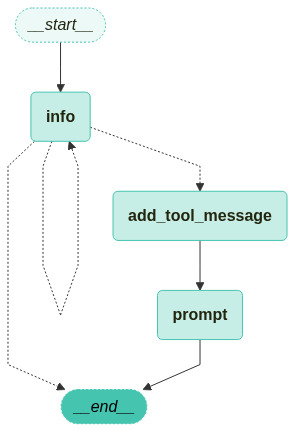

In [7]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 실행

이제 생성한 그래프를 실행하여 프롬프트를 생성합니다.

In [ ]:
import uuid
from langchain_teddynote.messages import stream_graph

def run_prompt_generator():
    """GPT-5 최적화된 프롬프트 생성기 실행"""
    
    # 구성 설정 초기화 (고유한 thread_id 생성)
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    print("🤖 **GPT-5 최적화 프롬프트 생성기에 오신 것을 환영합니다!**")
    print("📝 프롬프트 생성을 위한 요구사항을 수집하겠습니다.")
    print("💡 언제든지 'q' 또는 'Q'를 입력하면 종료됩니다.\n")
    
    while True:
        try:
            # 사용자 입력 받기
            print("=" * 60)
            user = input("🗣️  **사용자 입력**: ")
            print()
            
        except (KeyboardInterrupt, EOFError):
            print("\n👋 프로그램을 종료합니다. 감사합니다!")
            break
        
        # 종료 조건 확인
        if user.lower() in {'q', 'quit', 'exit', '종료', '끝'}:
            print("👋 프롬프트 생성기를 종료합니다. 좋은 하루 되세요!")
            break
        
        # 빈 입력 처리
        if not user.strip():
            print("⚠️  입력이 비어있습니다. 프롬프트에 대한 요구사항을 입력해 주세요.")
            continue
        
        try:
            # 그래프 실행 및 스트리밍
            print("🔄 **처리 중...**\n")
            
            stream_graph(
                graph,
                {"messages": [HumanMessage(content=user)], "progress": "시작"},
                config=config,
                node_names=["info", "prompt", "add_tool_message"],
            )
            
            print("\n✅ **프롬프트 생성 완료!**")
            print("📌 생성된 프롬프트를 복사하여 사용하세요.\n")
            
        except Exception as e:
            print(f"❌ **오류 발생**: {str(e)}")
            print("🔄 다시 시도해 주세요.\n")

# 프롬프트 생성기 실행
if __name__ == "__main__":
    run_prompt_generator()
else:
    # 노트북에서 실행할 때
    print("📚 **실행 방법:**")
    print("💻 `run_prompt_generator()` 함수를 호출하여 시작하세요.")
    print("🔧 또는 아래 코드를 직접 실행하세요:\n")
    
    # 간단한 실행 예제
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    print("🤖 GPT-5 최적화 프롬프트 생성기 준비 완료!")
    print("💬 대화를 시작하려면 다음과 같이 입력하세요:")
    print("```python")
    print("user_input = \"블로그 포스트 작성을 위한 프롬프트를 만들고 싶어요\"")
    print("stream_graph(graph, {'messages': [HumanMessage(content=user_input)], 'progress': '시작'}, config=config)")
    print("```")

🤖 **GPT-5 최적화 프롬프트 생성기에 오신 것을 환영합니다!**
📝 프롬프트 생성을 위한 요구사항을 수집하겠습니다.
💡 언제든지 'q' 또는 'Q'를 입력하면 종료됩니다.


🔄 **처리 중...**


🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 프롬프트 생성을 도와드리겠습니다. 먼저, 이 프롬프트의 주요 목표가 무엇인지 알려주시겠어요? 그리고 어떤 분야나 상황에서 사용될 예정인지도 말씀해 주세요.
✅ **프롬프트 생성 완료!**
📌 생성된 프롬프트를 복사하여 사용하세요.


🔄 **처리 중...**


🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋습니다. 문서 기반 검색 시스템을 위한 프롬프트를 생성하려고 하시는군요. 이 프롬프트의 주요 목표는 무엇인가요? 예를 들어, 검색 정확도를 높이거나 사용자 경험을 개선하는 것일 수 있습니다.
✅ **프롬프트 생성 완료!**
📌 생성된 프롬프트를 복사하여 사용하세요.


🔄 **처리 중...**


🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
이해했습니다. SK 에코플랜트의 건설 도메인에서 문서 기반 검색 시스템을 위한 프롬프트를 생성하려고 하시는군요. 이 프롬프트의 주요 목표는 무엇인가요? 예를 들어, 검색 정확도를 높이거나 특정 정보를 빠르게 찾는 것 등이 있을 수 있습니다.
✅ **프롬프트 생성 완료!**
📌 생성된 프롬프트를 복사하여 사용하세요.


🔄 **처리 중...**


🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
알겠습니다. 문서 내에서 정확한 정보를 검색하는 것이 목표군요. 추가적으로, 출력 형식이나 톤, 스타일에 대한 요구사항이 있으신가요? 예를 들어, 검색 결과를 JSON 형식으로 출력하